In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

from scipy.interpolate import interp1d

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['trapz']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Расчет

Некоторые константы

In [2]:
Q_EC_127Xe=0.662 #in MeV
Z_127Xe=54

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 
Be862_en = 0.862 #Mev

S_n = 7.246 #энергия отрыва нейтрона

total_GT = 53.54
#total_GT = 63

Функция для расчета порога реакции

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [6]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-functions

In [7]:
Suslov_Z53 = pd.read_excel('../../fermi_func_tables/suslov/suslov_Z=53.xls')
#Fermi_func.info()
def Suslov_func2(x, Suslov_data=Suslov_Z53):
    #input привиденная энергия электрона
    return np.interp(x, xp = Suslov_data['E_kev']/511 + 1, fp = Suslov_data['Value'])

def Suslov_func(x, Suslov_data=Suslov_Z53):
    #input привиденная энергия электрона
    f = interp1d(x=Suslov_data['E_kev']/511 + 1, y=Suslov_data['Value'], kind='linear', 
                 fill_value='extrapolate')
    return f(x)

In [8]:
Janecki_Z54 = pd.read_excel('../../fermi_func_tables/from_1968/Janecki Z54.xls')

def Janecki_func2(e_e, Janecki_data=Janecki_Z54):
    #input привиденная энергия электрона 
    e_e3 = np.sqrt( np.square( Janecki_data['p0'].values ) + 1 )
    return np.interp(x = e_e, xp = e_e3, 
                     fp = Janecki_data['Value'])

def Janecki_func(e_e, Janecki_data=Janecki_Z54):
    #input привиденная энергия электрона 
    e_e3 = np.sqrt( np.square( Janecki_data['p0'].values ) + 1 )
    f = interp1d(x=e_e3, y= Janecki_data['Value'], kind='linear', fill_value='extrapolate')
    return f(e_e)

Ферми функция через гамму: $F(Z_f, E) = 2(\gamma_1+1)(2pR_{A})^{2(\gamma_1-1)}\frac{|\Gamma(\gamma_1+iy)|^2}{[\Gamma(2\gamma_1+1)]^2}e^{{\pi}y}$  
$y = \frac{{\alpha}Z_fE}{p}$, $\gamma_1 = \sqrt{1-(Z_f\alpha)^2}$, $R_A = 1.2A^{1/3}$ fm.  
E, p в единицах mc^2 и mc #см. начало Behrens and Janecki

In [9]:
def Fermi_via_Gamma(E, Z = Z_127Xe, A = 127):
    #input привиденная энергия электрона 
    alpha = 1/137
    p = Pi_e_func(E)
    if p == 0 : return 0
    y = alpha*Z*E/p
    gamma1 = np.sqrt(1-(Z*alpha)**2)
    R = 1.2*np.cbrt(A)
    
    part1 = (2*gamma1+1)*(2*p*R)**(2*gamma1-2)
    part2 = np.square(np.abs(sc.special.gamma(gamma1+1j*y)))
    part3 = np.square(sc.special.gamma(2*gamma1+1))
    part4 = np.exp(np.pi*y)
    return part1*(part2/part3)*part4

def Fermi_via_Gamma2(E, Z = Z_127Xe, A = 127):
    #input привиденная энергия электрона 
    alpha = 1/137
    
    #исключаем деление на ноль
    for_sqrt = E**2 - 1
    mask = for_sqrt > 0
    p = np.where(mask, np.sqrt(for_sqrt), 1)
    
    y = alpha*Z*E/p
    gamma1 = np.sqrt(1-(Z*alpha)**2)
    R = 1.2*np.cbrt(A)
    
    part1 = (2*gamma1+1)*(2*p*R)**(2*gamma1-2)
    part2 = np.square(np.abs(sc.special.gamma(gamma1+1j*y)))
    part3 = np.square(sc.special.gamma(2*gamma1+1))
    part4 = np.exp(np.pi*y)
    result = part1*(part2/part3)*part4
    return mask * result

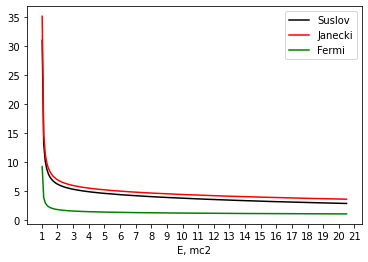

In [10]:
x_val = np.arange(0.01, 10, 0.05) / 0.511 + 1
plt.plot(x_val, Suslov_func(x_val), c='k', label = 'Suslov')
plt.plot(x_val, Janecki_func(x_val), c='r', label = 'Janecki')
plt.plot(x_val, [Fermi_via_Gamma(E) for E in x_val], c='g', label = 'Fermi')
plt.xticks(np.arange(1,22,1))
plt.legend()
plt.xlabel('E, mc2')
plt.show()

### BS05_OP flux

In [11]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [12]:
step_all_fluxes = 0.001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [13]:
def return_flux(pp_ampl, hep_ampl, B_ampl, N_ampl, O_ampl, F_ampl, 
                energy_list = Energy_all_fluxes):
    pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
    b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
    hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
    n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
    o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
    f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

    flux = {
        'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                       fp=pp['Probability'].values * pp_ampl ),
        'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * B_ampl ),
        'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                       fp=hep['Probability'].values * hep_ampl ),
        'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                       fp=n13['Probability'].values * N_ampl ),
        'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                       fp=o15['Probability'].values * O_ampl ),
        'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                       fp=f17['Probability'].values * F_ampl ),
    }
    return flux

In [14]:
BS05OP_flux = return_flux(pp_ampl=BS05OP_pp, 
                          hep_ampl=BS05OP_hep,
                          B_ampl=BS05OP_B,
                          N_ampl=BS05OP_N,
                          O_ampl=BS05OP_0,
                          F_ampl=BS05OP_F)

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z, \epsilon_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [15]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [16]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC, fermi_func):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=fermi_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [17]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, 
              func_Be_ampl = BS05OP_Be, name = 'test1'):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    output_dict = {'name':name}
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        #print(elem, ' ', rate)
        output_dict[elem] = rate
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    #print('pep', ' ', rate_pep)
    output_dict['pep'] = rate_pep
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    #print('Be', ' ', rate_Be)
    output_dict['Be'] = rate_Be
    rate_total+=rate_Be
    
    #print('rate_total',' ', rate_total)
    output_dict['Total'] = rate_total
    return output_dict

In [18]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [19]:
#continious part
#bgt_cont_x1 = np.arange(3, 3.5, 0.01)
#bgt_cont_y1 = np.ones(bgt_cont_x1.shape)
#bgt_cont_y1 = bgt_cont_y1 / trapz(bgt_cont_y1, bgt_cont_x1) * BGT_data['3-3.5'][0]

#bgt_cont_x2 = np.arange(3.5, 4, 0.01)
#bgt_cont_y2 = np.ones(bgt_cont_x2.shape)
#bgt_cont_y2 = bgt_cont_y2 / trapz(bgt_cont_y2, bgt_cont_x2) * BGT_data['3.5-4'][0]

#bgt_cont_x0 = np.arange(0, 3, 0.01)
#bgt_cont_y0 = np.zeros(bgt_cont_x0.shape)

#bgt_cont_x3 = np.arange(4, 20, 0.01)
#bgt_cont_y3 = np.zeros(bgt_cont_x3.shape)

#bgt_cont_x = np.concatenate((bgt_cont_x0, bgt_cont_x1, bgt_cont_x2, bgt_cont_x3))
#bgt_cont_y = np.concatenate((bgt_cont_y0, bgt_cont_y1, bgt_cont_y2, bgt_cont_y3))

#trapz(bgt_cont_y1, bgt_cont_x1), trapz(bgt_cont_y2, bgt_cont_x2), trapz(bgt_cont_y, bgt_cont_x), bgt_cont_x.shape, bgt_cont_y.shape

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [20]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data, fermi_func):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*fermi_func(e_energy/0.511) 


In [21]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [22]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, fermi_func, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y, fermi_func))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

сечение с Sn

### данные из графика BGT

In [23]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

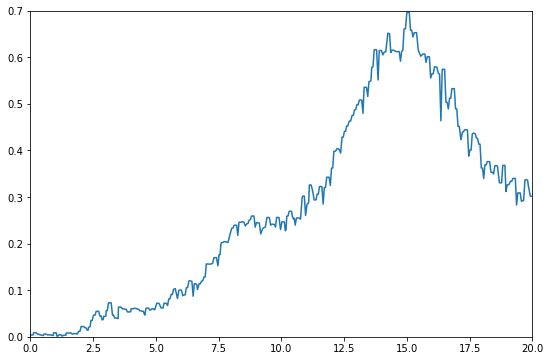

In [24]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [25]:
trapz(bgt['y'].values, bgt['x'].values)

5.463277472256921

(0.0, 7.0)

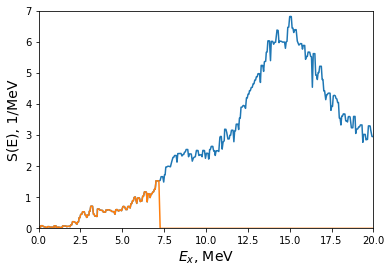

In [26]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)


#plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(bgt['x'].values, y_bgt, )
plt.plot(bgt['x'].values, y_bgt_border, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)


In [27]:
p_list = np.arange(0,20, 0.01) #p = z - Q

In [28]:
sigma_bgt_border_Janecki = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt_border, Janecki_func, 200) for p in p_list]
sigma_bgt_border_Janecki = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_border_Janecki)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [29]:
sigma_bgt_border_Suslov = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt_border, Suslov_func, 200) for p in p_list]
sigma_bgt_border_Suslov = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_border_Suslov)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [30]:
sigma_bgt_border_Fermi = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt_border, Fermi_via_Gamma2, 200) for p in p_list]
sigma_bgt_border_Fermi = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_border_Fermi)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

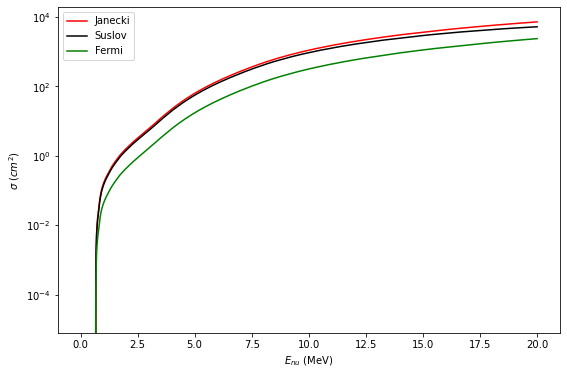

In [31]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_bgt_border_Janecki, c='r', label = 'Janecki')
plt.plot(Energy_all_fluxes, sigma_bgt_border_Suslov, c='k', label = 'Suslov')
plt.plot(Energy_all_fluxes, sigma_bgt_border_Fermi, c='g', label = 'Fermi')
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')

/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 0, '$E_{nu}$ (MeV)')

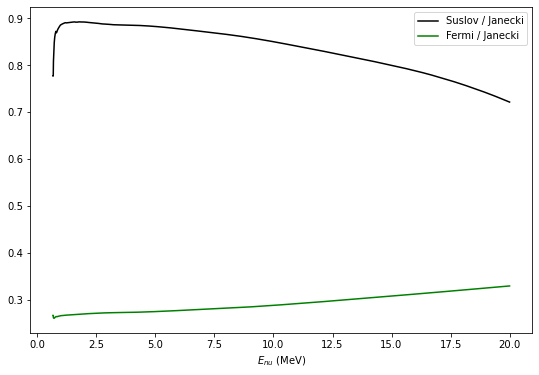

In [32]:
plt.figure(figsize=(9,6))
#plt.plot(Energy_all_fluxes, sigma_less5_Janecki, c='r', label = 'Janecki')
Suslov_Jan = sigma_bgt_border_Suslov / sigma_bgt_border_Janecki
Fermi_Jan = sigma_bgt_border_Fermi / sigma_bgt_border_Janecki

plt.plot(Energy_all_fluxes, Suslov_Jan, c='k', label = 'Suslov / Janecki')
plt.plot(Energy_all_fluxes, Fermi_Jan, c='g', label = 'Fermi / Janecki')
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
#plt.ylabel('$\sigma$ $(cm^2)$')
#plt.yscale('log')

/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/almaz/miniconda3/envs/science/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


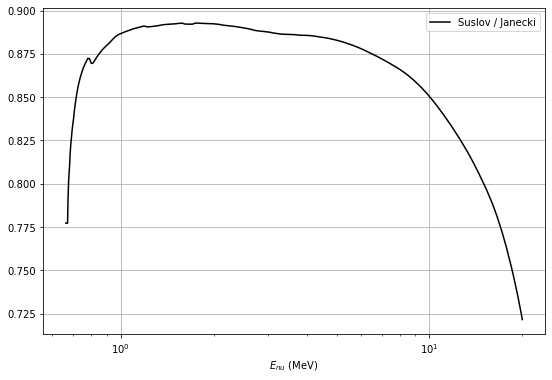

In [44]:
plt.figure(figsize=(9,6))
#plt.plot(Energy_all_fluxes, sigma_less5_Janecki, c='r', label = 'Janecki')
Suslov_Jan = sigma_bgt_border_Suslov / sigma_bgt_border_Janecki
Fermi_Jan = sigma_bgt_border_Fermi / sigma_bgt_border_Janecki

plt.plot(Energy_all_fluxes, Suslov_Jan, c='k', label = 'Suslov / Janecki')
#plt.plot(Energy_all_fluxes, Fermi_Jan, c='g', label = 'Fermi / Janecki')
plt.legend()
plt.xlabel('$E_{nu}$ (MeV)')
plt.grid(True)
#plt.xlim(10**(-0.9),10**1)
#plt.ylabel('$\sigma$ $(cm^2)$')
plt.xscale('log')

### BS05OP

In [33]:
rate_calc(sigma_bgt_border_Janecki, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 25.706047213209956,
 'hep': 0.10863862045636702,
 'n13': 0.1646993144869732,
 'o15': 0.5511506137488628,
 'f17': 0.013972879196773182,
 'pep': 0.8281994486359651,
 'Be': 2.9232968031779256,
 'Total': 30.296004892912826}

In [34]:
rate_calc(sigma_bgt_border_Suslov, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 21.881159738608968,
 'hep': 0.08911073889639085,
 'n13': 0.14566121565968568,
 'o15': 0.49081213657970474,
 'f17': 0.012443535260837814,
 'pep': 0.7389055569223173,
 'Be': 2.5621711037070085,
 'Total': 25.920264025634918}

In [35]:
rate_calc(sigma_bgt_border_Fermi, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'name': 'test1',
 'pp': 0.0,
 'b8': 7.386999556431921,
 'hep': 0.03252502375545081,
 'n13': 0.04370516653259388,
 'o15': 0.14724375065565407,
 'f17': 0.0037331637608525527,
 'pep': 0.22170959570882368,
 'Be': 0.7717332443755569,
 'Total': 8.607649501220852}